In [ ]:
import cv2
import torch
from rembg import remove
import numpy as np


def get_depth_map(image, model_type="DPT_Hybrid"):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    midas = torch.hub.load("intel-isl/MiDaS", model_type)
    midas.to(device)
    midas.eval()

    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
    if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
        transform = midas_transforms.dpt_transform
    else:
        transform = midas_transforms.small_transform

    input_batch = transform(img).to(device)

    with torch.no_grad():
        prediction = midas(input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    output = prediction.cpu().numpy()
    depth_map_normalized = cv2.normalize(output, None, 0, 255, cv2.NORM_MINMAX)
    depth_map_8bit = depth_map_normalized.astype(np.uint8)

    return depth_map_8bit


def adjust_gamma(image, gamma=0.5):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)


def process(img, gamma=0.5, remove_bg=True, adj_contr=True, sharpen=True):
    output = img
    if remove_bg:
        output = remove(output, bgcolor=(0, 0, 0, 0))
    output = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
    if adj_contr:
        output = adjust_gamma(output, gamma)
    if sharpen:
        laplacian = cv2.Laplacian(output, cv2.CV_64F)
        laplacian_uint8 = cv2.convertScaleAbs(laplacian)
        output = cv2.addWeighted(output, 1, laplacian_uint8, 0.5, 0)
    return output


In [ ]:
image = cv2.imread("person.png")
depth_map = process(get_depth_map(image))

/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.l

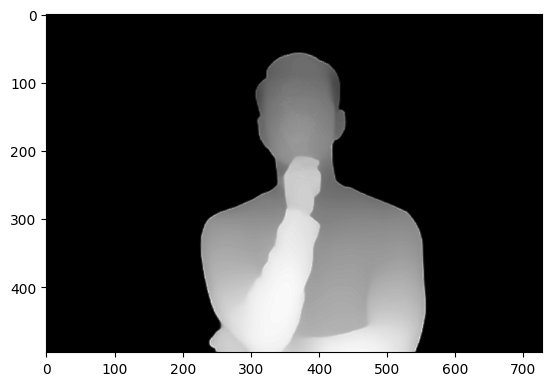

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(depth_map, cmap = 'gray')
plt.show()

In [ ]:
from PIL import Image

im = Image.fromarray(depth_map)
im.save("depth_map.png")

In [ ]:
import math

def generate_pattern(depth_map):
  size_x, size_y = depth_map.shape
  pattern = np.random.uniform(0,1, (size_y,64,3))
  return pattern


def generate_stereogram(depth_map, pattern):
  E = 3  # Distance between the observer's eyes (inches)
  b = 1.0 # Distance between the near and far plane
  a = 4 # Distance between the autostereogram plane and the near plane
  autostereogram = np.zeros(
        shape=[depth_map.shape[0], depth_map.shape[1], 3],
        dtype=pattern.dtype)
  for row in range(depth_map.shape[0]):
        for column in range(depth_map.shape[1]):
            # If the current column is smaller than the amount of columns
            # in the pattern
            if column < pattern.shape[1]:
                # Copy in the current row/col the pattern
                autostereogram[row][column] = pattern[
                    row % pattern.shape[0]][column]
                continue

            # otherwise, apply the autostereogram algorithm
            grey_value = depth_map[row, column]
            s_on_two = math.floor(
                (
                    ((a - (b * grey_value / 255)) * E) / 2 *
                    (1 + a - (b * grey_value / 255))
                ) + 0.5
            )
            autostereogram[row][column] = autostereogram[
                row][column - pattern.shape[1] + s_on_two]
            if column - pattern.shape[1] - s_on_two > 0:
                autostereogram[row][column] = autostereogram[
                    row][column - pattern.shape[1] - s_on_two]
  return autostereogram


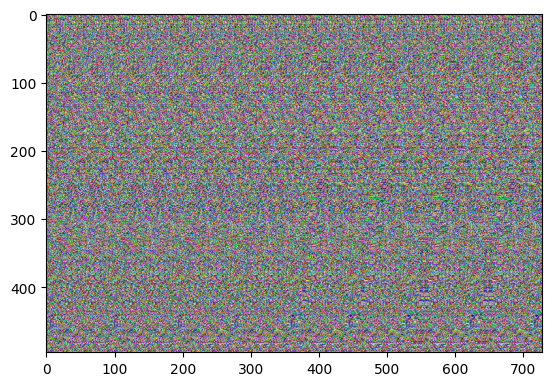

In [ ]:
pattern = generate_pattern(depth_map)
stereogram = generate_stereogram(depth_map, pattern)

plt.imshow(stereogram)
plt.show()

In [ ]:
from PIL import Image

In [ ]:
def generate_stereo_gif(giffile, pattern):
  gif = Image.open(giffile)

  frames = []
  for frame in range(gif.n_frames):
    gif.seek(frame)
    frame_array = np.array(gif.convert("RGB"))
    frame_array = cv2.cvtColor(frame_array, cv2.COLOR_RGB2BGR)
    frames.append(frame_array)

  stereogram_frames = []
  for frame in frames:
    depth_map = get_depth_map(frame)
    stereogram = generate_stereogram(depth_map, pattern)
    stereogram = np.clip(stereogram*255, 0, 255)
    stereogram_image = Image.fromarray(np.uint8(stereogram))
    stereogram_frames.append(stereogram_image)

  stereogram_frames[0].save('stereogram_output.gif',
                          save_all=True,
                          append_images=stereogram_frames[1:],
                          loop=0,  # Loop the GIF
                          duration=gif.info['duration'])


In [ ]:
generate_stereo_gif("homer.gif", pattern)

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_Mi

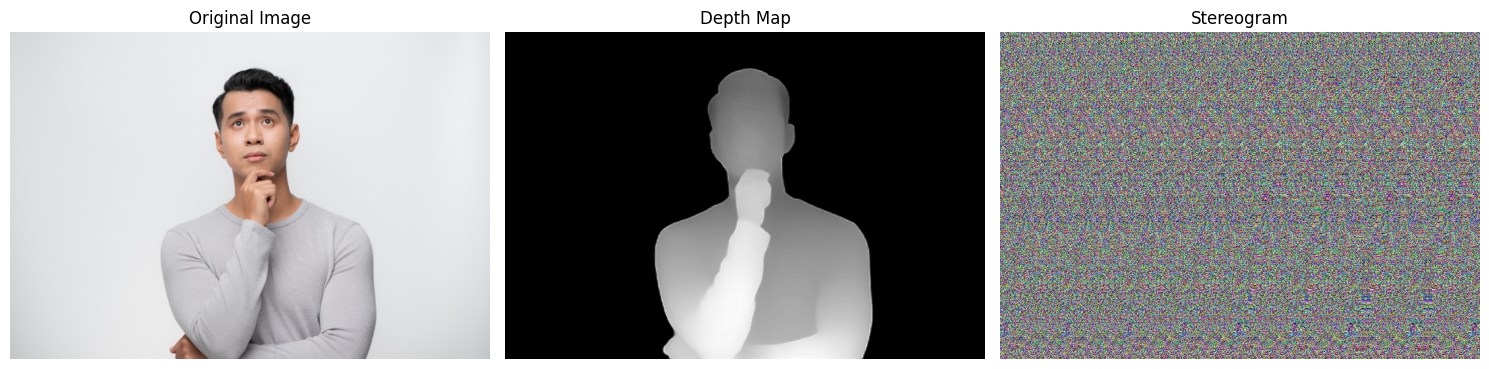

In [ ]:
# prompt: show 3 pictures in a row,  image, depth map and stereogram variables. Not paths, just image, depth_map and stereogram. They are already initialized

import matplotlib.pyplot as plt

# Assuming 'image', 'depth_map', and 'stereogram' are already NumPy arrays representing images

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure and 3 subplots

axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(depth_map, cmap='gray')
axes[1].set_title('Depth Map')
axes[1].axis('off')

axes[2].imshow(stereogram)
axes[2].set_title('Stereogram')
axes[2].axis('off')

plt.tight_layout()
plt.show()